# Train a variational autoencoder to perform clustering on the MNIST data set. Part 2.

With this exercises I'm trying to learn the basics of training an ANN with Keras.

The objective is to construct a VAE and pre-train it on the MNIST data set, then add a layer that performs clustering on the embeddings and fine-tune the model balancing the three losses:
- Reconstruction loss (ensure that it extracts good latent features, so we can reconstruct the input from the embeddings).
- KL-divergence loss (ensure that the mebeddings follow a mixture of gaussians distribution, so that we can infer some mining on the latent space and are able to generate new images).
- Clustering loss (ensure that we achieve good clustering quality).

---

**In this second part,** I will load the pretrained model from part 1 and add a classification layer. The main objective is to learn how to manage multiple outputs and multiple loss functions.

# Prepare some things...

First, we will import the necessary libraries and the MNIST data set. Then wee will define some functions we will reuse from part 1. An finally, we will construct our VAE and load the pre-trained weights from part 1.

## Import libraries

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

from sklearn.cluster import KMeans
import sklearn.metrics

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Load and prepare the MNIST data set

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

In [3]:
x_train = np.expand_dims(x_train, -1).astype("float")/255
x_test = np.expand_dims(x_test, -1).astype("float")/255

## Reuse some functions

In [4]:
def kmeans_crosstab(x, y, k=10):
    kmeans = KMeans(n_clusters=k, n_init=30)
    kmeans.fit(x)

    confusion_matrix = sklearn.metrics.confusion_matrix(y, kmeans.labels_)
    heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
    heatmap.set(xlabel='clusters', ylabel='true labels')

    return kmeans

In [5]:
def kmeans_performance(kmeans, true_labels):
    confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, kmeans.labels_)
    clust_labels = confusion_matrix.argmax(0)[kmeans.labels_]

    acc = sklearn.metrics.accuracy_score(y_test, clust_labels)
    print("Acc: %0.4f" % acc)
    print("ARI: %0.4f" % sklearn.metrics.adjusted_rand_score(true_labels, kmeans.labels_))
    print("AMI: %0.4f" % sklearn.metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_))
    # X = points passed to Kmeans
    # print("Sil:", sklearn.metrics.silhouette_score(X, true_labels))

In [6]:
def plot_latent_space(z, labels,
                      centroids = None,
                      figsize=(10,10),
                      legend_title = "Labels",
                      alpha=0.2
                      ):
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:,0],
                        z[:,1],
                        label=labels,
                        c=labels,
                        cmap="tab10",
                        alpha=alpha,
                        linewidths=0,
                        )

    if centroids is not None:
        plt.scatter(centroids[:,0],
                    centroids[:,1],
                    c="black",
                    marker="x",
                    )

    leg = plt.legend(*scatter.legend_elements(), title=legend_title)
    # Make points in legend opaque
    for lh in leg.legendHandles: 
        # lh._legmarker.set_alpha(1) # old version of matplotlib
        lh.set_alpha(1)            # new version of matplotlib

    plt.show()

In [7]:
def compare(x):
    index = random.randint(0, x.shape[0])
    original = x[[index]]
    res = original.shape[1]
    figure = np.zeros((res, res*2))

    # Save the original image
    figure[0:res, 0:res] = original.reshape(res, res)

    # Encode it
    z, _ = encoder.predict(original, verbose=0)
    # Decode it (use the predicted mean, no need to sample from the distribution)
    decoded = decoder.predict(z, verbose=0)
    # Save the the reconstructed image
    reconstructed = decoded[0].reshape(res, res)
    figure[0:res, res:res*2] = reconstructed

    # Show original and reconstructed
    plt.figure()
    plt.axis("off")
    plt.imshow(figure, cmap="Greys_r")

## Construct the VAE

### Encoder

In [8]:
class ConvBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding="same")
        self.conv2 = layers.Conv2D(filters, 3, padding="same")
        self.strides = layers.Conv2D(filters, 3, strides=2, padding="same")
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)
        
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.strides(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return x

In [9]:
class Encoder(keras.Model):
    def __init__(self, latent_dim = 2, name=None):
        super(Encoder, self).__init__(name=name)
        self.latent_dim = latent_dim
        self.conv_block_1 = ConvBlock(32)
        self.conv_block_2 = ConvBlock(64)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(16, activation="relu")
        self.z_mean = layers.Dense(self.latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(self.latent_dim, name="z_log_var")

    def call(self, encoder_inputs):
        x = self.conv_block_1(encoder_inputs)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.dense(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        
        # Custom loss: KL-divergence
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        self.add_loss(kl_loss)
        # Add it also as a metric so it will show on the training output
        self.add_metric(kl_loss, name="kl_loss")
        
        return (z_mean, z_log_var)

In [10]:
latent_dim = 2
encoder = Encoder(latent_dim = latent_dim, name="encoder")

### Sampler and decoder

In [11]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
class DeconvBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.stridesT = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")
        self.convT1 = layers.Conv2DTranspose(filters, 3, padding="same")
        self.convT2 = layers.Conv2DTranspose(filters, 3, padding="same")
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)
        
    def call(self, inputs, training=False):
        x = self.stridesT(inputs)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return x

In [13]:
class Decoder(keras.Model):
    def __init__(self, name=None):
        super(Decoder, self).__init__(name=name)
        self.dense = keras.layers.Dense(7 * 7 * 64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.deconv_block_1 = DeconvBlock(64)
        self.deconv_block_2 = DeconvBlock(32)
        self.outputs = layers.Conv2D(1, 3,
                                      activation="sigmoid",
                                      padding="same",
                                      name="decoder_outputs")
        
    def call(self, decoder_inputs):
        x = self.dense(decoder_inputs)
        x = self.reshape(x)
        x = self.deconv_block_1(x)
        x = self.deconv_block_2(x)
        decoder_outputs = self.outputs(x)
        
        return decoder_outputs

In [14]:
decoder = Decoder(name="decoder")

### VAE model

In [15]:
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_inputs")
z_mean, z_log_var = encoder(encoder_inputs)
z = Sampler(name="sampler") (z_mean, z_log_var)
decoder_outputs = decoder(z)

vae = keras.Model(encoder_inputs, decoder_outputs, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 2),          161812      ['encoder_inputs[0][0]']         
                                 (None, 2))                                                       
                                                                                                  
 sampler (Sampler)              (None, 2)            0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                                

### Define the reconstruction loss function, prepare the callbacks list

In [16]:
# Define the custom loss 
def reconstruction_loss(x, y):
    loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(x, y),
            axis=(1, 2)
        )
    )
    return loss

In [17]:
patience = 10

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
    )
]

### Load the pre-trained weights

In [18]:
vae.load_weights("models/vae_full/weights")

# Add a classification layer

Before trying to add a clustering loss (and since I've been fighting with this for days), let's try doing something a little more simple. We'll reuse the pretrained encoder and decoder parts of the VAE and add a classification layer, that will take the sampled embeddings and try to predict the label correctly.

We will need to add a new loss for the classification layer (we will use the `categorical_crossentropy` packages with Keras). Also, we will have the provide the labels to the `model.train()` so it can compute the loss.

In [19]:
# First, encode the labels with one-hot encoding so we can pass them to the model as targets
onehot_train = to_categorical(y_train)
onehot_test = to_categorical(y_test)

## Construct the new model

In [20]:
# Construct the classifier model
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_inputs")
z_mean, z_log_var = encoder(encoder_inputs)
z = Sampler(name="sampler") (z_mean, z_log_var)
decoder_outputs = decoder(z)

class_outputs = layers.Dense(10, activation="softmax", name="classifier") (z)

class_vae = keras.Model(encoder_inputs, [decoder_outputs, class_outputs], name='class_vae')
class_vae.summary()

Model: "class_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 2),          161812      ['encoder_inputs[0][0]']         
                                 (None, 2))                                                       
                                                                                                  
 sampler (Sampler)              (None, 2)            0           ['encoder[1][0]',                
                                                                  'encoder[1][1]']                
                                                                                          

## Train the model and save the weights

In [21]:
# Compile the model. We specify a different loss for each output
class_vae.compile(optimizer="adam",
            loss={"decoder": reconstruction_loss,
                  "classifier": "categorical_crossentropy"
                 },
            )

In [ ]:
# And train it. Also, we spacify the targets for each output
epochs=50

class_vae.fit(x_train,
        {"decoder" : x_train,
         "classifier" : onehot_train,
        },
        epochs=epochs,
        batch_size=128,
        validation_data=(x_test, 
                         {"decoder" : x_test,
                          "classifier" : onehot_test,
                         }),
        callbacks = callbacks_list,
       )

Now we can save the weights as before

In [62]:
# Save the model weights (if the file exists, it will rewrite it)
# encoder.save_weights("models/classifier_encoder/weights")
# decoder.save_weights("models/classifier_decoder/weights")
# class_vae.save_weights("models/classifier_full/weights")

### Or load the previously saved weights

In [23]:
# Load the model weights
# encoder.load_weights("models/classifier_encoder/weights")
# decoder.load_weights("models/classifier_decoder/weights")
class_vae.load_weights("models/classifier_full/weights")

## Plot the embeddings

Let's take a look at the new embeddings distribution

In [24]:
z_class_test, _ = encoder.predict(x_test)

313/313 [==============================] - 3s 2ms/step


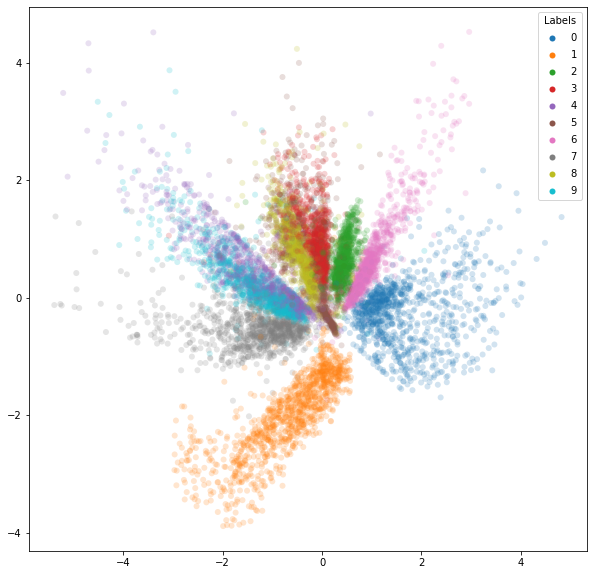

In [25]:
plot_latent_space(z_class_test, y_test)

It looks like the labels got more separated. It makes sense, since the classificaton loss we added applies some pressure to group the same labels more closely.

## Evaluate the model

Let's see how well we did with the classification:

In [30]:
_, preds = class_vae.predict(x_test)
preds = preds.argmax(1)

print("Acc: %0.4f" % sklearn.metrics.accuracy_score(y_test, preds))
print("ARI: %0.4f" % sklearn.metrics.adjusted_rand_score(y_test, preds))
print("AMI: %0.4f" % sklearn.metrics.adjusted_mutual_info_score(y_test, preds))

313/313 [==============================] - 1s 2ms/step
Acc: 0.7542
ARI: 0.6136
AMI: 0.6772


[Text(0.5, 15.0, 'predictions'), Text(33.0, 0.5, 'true labels')]

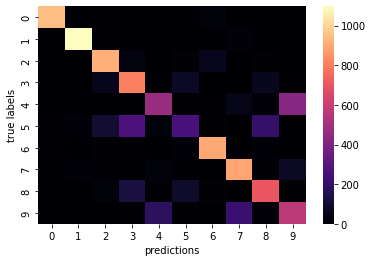

In [31]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='predictions', ylabel='true labels')

Not bad, but we did better with the CNN alone. But makes that sense it performes worse since we are compressing the data into a much smaller latent space, which also has another restriction: the points in the space need to be able to be reconstructed.

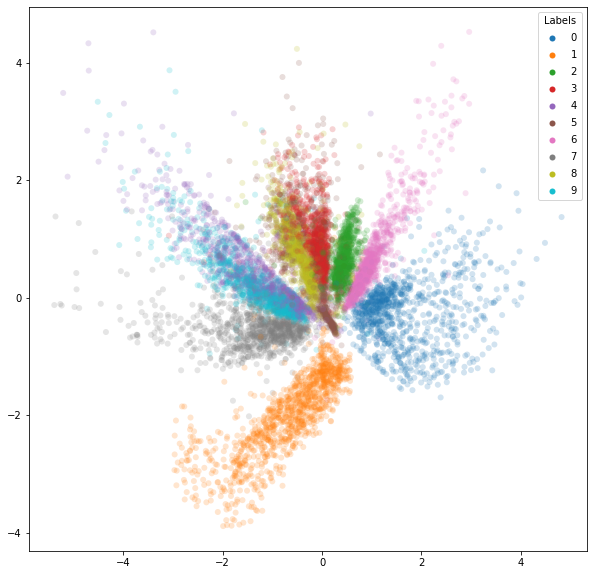

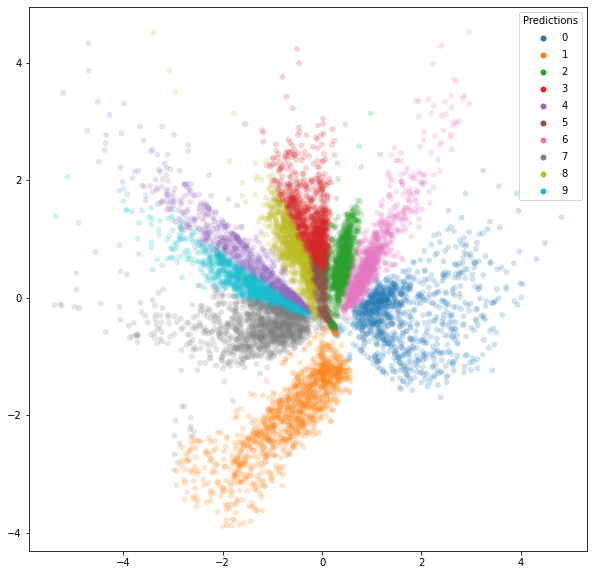

In [32]:
plot_latent_space(z_class_test, y_test)
plot_latent_space(z_class_test, preds, legend_title="Predictions")

It did pretty well, but still has problems separating the "sixes" and "nines", and the "threes", "fives", and "eights". It makes sense since they have similar shapes.

Is the model still able to compress and reconstruct the images?

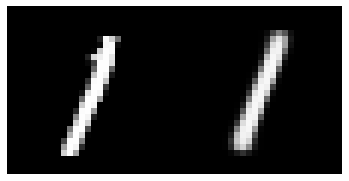

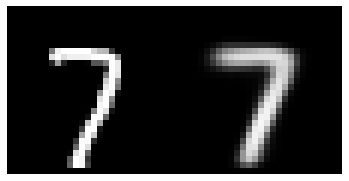

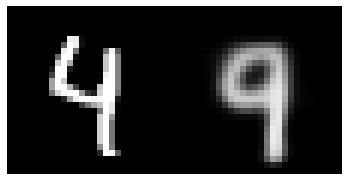

In [34]:
# Look at some examples
for _ in range(3):
    compare(x_test)